# Resnet152 model for Covid-19 classification

### Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from PIL import Image
import os
import matplotlib.pyplot as plt

from tqdm import tqdm
import time
import datetime


In [2]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed, 2))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Dataset Parser

In [3]:
class COVIDDataset(Dataset):
    def __init__(self, data_file, transform=None):
        self.data = []
        self.transform = transform
        self.map = {'negative': 0, 'positive': 1}
        
        with open(data_file, 'r') as f:
            folder = os.path.splitext(data_file)[0]
            for line in f:
                patient_id, filename, label, data_source = line.strip().split(' ')
                image_path = os.path.join(folder, filename)
                self.data.append((image_path ,self.map[label]))
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Create Model

In [4]:
# Define the modified ResNet152 model
class ModifiedResNet152(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ModifiedResNet152, self).__init__()
        if pretrained:
            self.resnet = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        else:
            self.resnet = models.resnet152()
        self.resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x
    

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.
    correct = 0.
    total = 0.
    print(f'Loading # {len(train_loader)} datas')
    
    with tqdm(train_loader, unit='batch') as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Training")
            data, target = data.to(device), target.to(device)

            # instead of  optimizer.zero_grad(), do it in forloop for more efficiency
            for param in model.parameters():
                param.grad = None

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
    acc = 100.*correct/total
    return train_loss, acc

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        with tqdm(val_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Validating")
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        
    acc = 100.*correct/total
    return val_loss, acc


In [ ]:
def train_resnet(model, dataset, lr, epochs, batch_size, factor, patience, criterion, device):
    """Train the model on the dataset and return the best accuracy
    
    Args:
        model: the model to train
        dataset: the dataset to train on
        lr: learning rate
        epochs: number of epochs to train for
        batch_size: batch size
        factor: factor for ReduceLROnPlateau
        patience: patience for ReduceLROnPlateau
        criterion: loss function
        device: device to train on (cuda or cpu)
        
    Returns:
        best_acc: best accuracy achieved
    """
    print(f"Using device: {device}")
    # get size of dataset
    dataset_size = len(dataset)
    print(f"Dataset size: {dataset_size}")
    # split dataset into train and validation sets
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=True)
    # record training and validation losses and accuracies
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_acc = 0

    start = time.time()
    print(f"Began training for {epochs} epochs")
    for epoch in range(epochs):
        print(f'Training (Epoch {epoch + 1})')
        torch.cuda.empty_cache()
        t0 = time.time()
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
        
        t0 = time.time()
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))

        # record training and validation losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'resnet152.pt')
    
    print("Training complete in {}".format(format_time(time.time() - start)))
    print("Best validation accuracy: {:.2f}%".format(best_acc))

    return train_losses, val_losses, train_accs, val_accs

### Begin Training process for RESNET152

In [5]:
# Set up hyperparameters for the model
# Set up hyperparameters and data loaders
# TUNABLE:
lr = 2e-4
# TUNABLE:
epochs = 22
# TUNABLE: original 64
batch_size = 16
# TUNABLE:
factor = 0.7
# TUNABLE:
patience = 5

num_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # Define the transformations to be applied to the data
target_size = 224
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# create COVIDDataset object
# TUNABLE: --> can try different datasets
dataset = COVIDDataset('train.txt', transform=transform)

# Define the model, loss function
model = ModifiedResNet152(num_classes, pretrained=False).to(device) # pretrained=False
# model = ModifiedResNet152(num_classes, pretrained=True).to(device) # pretrained=True
# TUNABLE:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

# Train the model
train_losses, val_losses, train_accs, val_accs = train_resnet(model, dataset, lr, epochs, batch_size, factor, patience, criterion, device)

# # Use the pretrained Resnet152. Load the trained ResNet152 model
# model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(2048, 1024),
#     torch.nn.ReLU(),
#     # torch.nn.Linear(1024, 2),
#     torch.nn.LogSoftmax(dim=1)
# )

# # Set the model to evaluation mode
# model.eval()

# # Initialize an empty tensor to store the features for all images
# all_features = torch.empty(len(dataset), 1024)

# # Pass each batch of images through the model to obtain the features
# with torch.no_grad():
#     start_index = 0
#     for images, _ in tqdm(train_loader):
#         batch_size = images.shape[0]
#         features = model(images)
#         all_features[start_index:start_index+batch_size,:] = features
#         start_index += batch_size


Using device: cuda
Dataset size: 29986
Began training for 22 epochs
Training (Epoch 1)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:17<00:00,  2.69batch/s]


  * Training epoch took: 0:09:17


Validating: 100%|██████████| 375/375 [01:38<00:00,  3.82batch/s]


  * Validation took: 0:01:38
Epoch 1, Train Loss: 529.9629, Train Acc: 84.05, Val Loss: 86.2187, Val Acc: 90.73
Training (Epoch 2)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:08<00:00,  2.73batch/s]


  * Training epoch took: 0:09:08


Validating: 100%|██████████| 375/375 [01:33<00:00,  4.03batch/s]


  * Validation took: 0:01:33
Epoch 2, Train Loss: 333.0662, Train Acc: 91.02, Val Loss: 67.4977, Val Acc: 93.41
Training (Epoch 3)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:52<00:00,  2.81batch/s]


  * Training epoch took: 0:08:52


Validating: 100%|██████████| 375/375 [01:32<00:00,  4.07batch/s]


  * Validation took: 0:01:32
Epoch 3, Train Loss: 276.9983, Train Acc: 93.00, Val Loss: 63.3431, Val Acc: 93.55
Training (Epoch 4)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:52<00:00,  2.82batch/s]


  * Training epoch took: 0:08:52


Validating: 100%|██████████| 375/375 [01:32<00:00,  4.04batch/s]


  * Validation took: 0:01:32
Epoch 4, Train Loss: 240.5613, Train Acc: 93.88, Val Loss: 71.5512, Val Acc: 93.05
Training (Epoch 5)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:52<00:00,  2.82batch/s]


  * Training epoch took: 0:08:52


Validating: 100%|██████████| 375/375 [01:31<00:00,  4.08batch/s]


  * Validation took: 0:01:32
Epoch 5, Train Loss: 217.0014, Train Acc: 94.46, Val Loss: 59.0318, Val Acc: 94.30
Training (Epoch 6)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:53<00:00,  2.81batch/s]


  * Training epoch took: 0:08:53


Validating: 100%|██████████| 375/375 [01:32<00:00,  4.06batch/s]


  * Validation took: 0:01:32
Epoch 6, Train Loss: 201.6699, Train Acc: 94.92, Val Loss: 50.5456, Val Acc: 94.85
Training (Epoch 7)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57


Validating: 100%|██████████| 375/375 [01:38<00:00,  3.82batch/s]


  * Validation took: 0:01:38
Epoch 7, Train Loss: 167.1471, Train Acc: 95.79, Val Loss: 45.9672, Val Acc: 95.43
Training (Epoch 8)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57


Validating: 100%|██████████| 375/375 [01:31<00:00,  4.09batch/s]


  * Validation took: 0:01:31
Epoch 8, Train Loss: 152.3498, Train Acc: 96.03, Val Loss: 42.8125, Val Acc: 95.50
Training (Epoch 9)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:52<00:00,  2.82batch/s]


  * Training epoch took: 0:08:52


Validating: 100%|██████████| 375/375 [01:33<00:00,  4.02batch/s]


  * Validation took: 0:01:33
Epoch 9, Train Loss: 139.4335, Train Acc: 96.60, Val Loss: 30.2544, Val Acc: 97.15
Training (Epoch 10)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:52<00:00,  2.82batch/s]


  * Training epoch took: 0:08:52


Validating: 100%|██████████| 375/375 [01:33<00:00,  4.01batch/s]


  * Validation took: 0:01:33
Epoch 10, Train Loss: 123.5480, Train Acc: 97.08, Val Loss: 30.2191, Val Acc: 97.02
Training (Epoch 11)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:52<00:00,  2.82batch/s]


  * Training epoch took: 0:08:52


Validating: 100%|██████████| 375/375 [01:32<00:00,  4.04batch/s]


  * Validation took: 0:01:32
Epoch 11, Train Loss: 114.2489, Train Acc: 97.37, Val Loss: 27.8579, Val Acc: 97.27
Training (Epoch 12)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:53<00:00,  2.81batch/s]


  * Training epoch took: 0:08:53


Validating: 100%|██████████| 375/375 [01:32<00:00,  4.06batch/s]


  * Validation took: 0:01:32
Epoch 12, Train Loss: 103.6490, Train Acc: 97.51, Val Loss: 27.7467, Val Acc: 97.45
Training (Epoch 13)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:01<00:00,  2.77batch/s]


  * Training epoch took: 0:09:01


Validating: 100%|██████████| 375/375 [02:04<00:00,  3.00batch/s]


  * Validation took: 0:02:04
Epoch 13, Train Loss: 94.0911, Train Acc: 97.77, Val Loss: 23.1038, Val Acc: 97.78
Training (Epoch 14)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:34<00:00,  2.61batch/s]


  * Training epoch took: 0:09:34


Validating: 100%|██████████| 375/375 [02:23<00:00,  2.62batch/s]


  * Validation took: 0:02:23
Epoch 14, Train Loss: 89.6760, Train Acc: 97.82, Val Loss: 26.7842, Val Acc: 97.27
Training (Epoch 15)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [12:00<00:00,  2.08batch/s]


  * Training epoch took: 0:12:00


Validating: 100%|██████████| 375/375 [02:24<00:00,  2.60batch/s]


  * Validation took: 0:02:24
Epoch 15, Train Loss: 80.4890, Train Acc: 98.06, Val Loss: 34.4102, Val Acc: 96.47
Training (Epoch 16)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:44<00:00,  2.57batch/s]


  * Training epoch took: 0:09:44


Validating: 100%|██████████| 375/375 [01:34<00:00,  3.96batch/s]


  * Validation took: 0:01:34
Epoch 16, Train Loss: 75.3718, Train Acc: 98.09, Val Loss: 24.4290, Val Acc: 97.60
Training (Epoch 17)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [10:17<00:00,  2.43batch/s]


  * Training epoch took: 0:10:17


Validating: 100%|██████████| 375/375 [02:24<00:00,  2.60batch/s]


  * Validation took: 0:02:24
Epoch 17, Train Loss: 68.2422, Train Acc: 98.39, Val Loss: 22.6874, Val Acc: 97.80
Training (Epoch 18)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [12:16<00:00,  2.04batch/s]


  * Training epoch took: 0:12:16


Validating: 100%|██████████| 375/375 [02:22<00:00,  2.62batch/s]


  * Validation took: 0:02:22
Epoch 18, Train Loss: 66.4997, Train Acc: 98.38, Val Loss: 25.2929, Val Acc: 97.47
Training (Epoch 19)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [12:15<00:00,  2.04batch/s]


  * Training epoch took: 0:12:15


Validating: 100%|██████████| 375/375 [01:35<00:00,  3.92batch/s]


  * Validation took: 0:01:35
Epoch 19, Train Loss: 61.9994, Train Acc: 98.47, Val Loss: 30.0048, Val Acc: 97.20
Training (Epoch 20)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:28<00:00,  2.64batch/s]


  * Training epoch took: 0:09:28


Validating: 100%|██████████| 375/375 [01:36<00:00,  3.88batch/s]


  * Validation took: 0:01:36
Epoch 20, Train Loss: 55.6351, Train Acc: 98.65, Val Loss: 35.9825, Val Acc: 97.10
Training (Epoch 21)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:41<00:00,  2.58batch/s]


  * Training epoch took: 0:09:41


Validating: 100%|██████████| 375/375 [01:34<00:00,  3.98batch/s]


  * Validation took: 0:01:34
Epoch 21, Train Loss: 51.5387, Train Acc: 98.76, Val Loss: 25.6131, Val Acc: 97.67
Training (Epoch 22)
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:30<00:00,  2.63batch/s]


  * Training epoch took: 0:09:30


Validating: 100%|██████████| 375/375 [01:35<00:00,  3.93batch/s]

  * Validation took: 0:01:35
Epoch 22, Train Loss: 50.2080, Train Acc: 98.80, Val Loss: 26.6525, Val Acc: 97.60
Best validation accuracy: 97.80%
Training complete in 4:09:38


### Plot the loss and accuracy

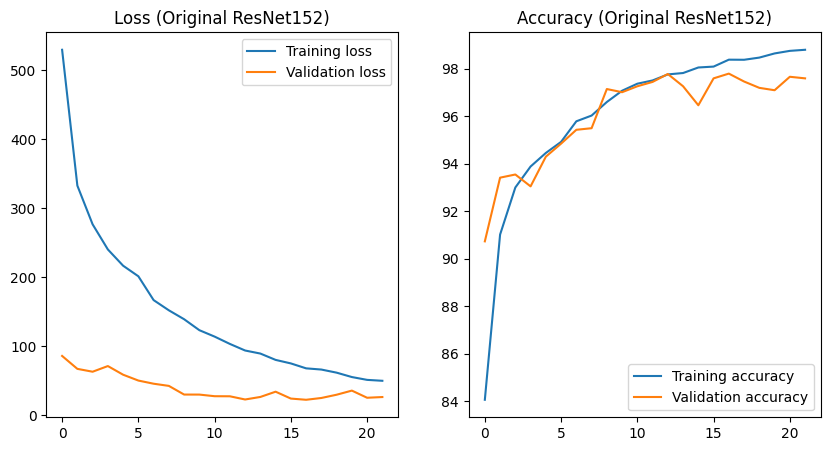

In [12]:
# plot training and validation losses and accuracies
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H%M%S")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss (Original ResNet152)")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy (Original ResNet152)")
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.savefig('./resnet_plots/' + f'loss_resnet152_{now}.png')
plt.show()

### Test the resnet model

In [9]:
# test data
test_dataset = COVIDDataset('test.txt', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load best model
model.load_state_dict(torch.load('resnet152.pt'))

# evaluate model on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%')

Validating: 100%|██████████| 25/25 [00:22<00:00,  1.13batch/s]

Test loss: 6.0612, Test accuracy: 91.00%
